In [11]:
# load Python/Theano stuff
# Show figures inline with the code
%matplotlib inline   

import theano
import theano.tensor as T
import theano.tensor.nlinalg as Tla
import lasagne       # the library we're using for NN's
# import the nonlinearities we might use 
from lasagne.nonlinearities import leaky_rectify, softmax, linear, tanh, rectify
from theano.tensor.shared_randomstreams import RandomStreams
import numpy as np
from numpy.random import *
from matplotlib import pyplot as plt

import cPickle
import sys

# import kmeans clustering algorithm from scikit-learn
from sklearn.cluster import KMeans 


In [12]:
# Load our code

# Add all the paths that should matter right now
sys.path.append('lib/') 
from GenerativeModel import *       # Class file for generative models. 
from RecognitionModel import *      # Class file for recognition models
from NVIL import *                  # The meat of the algorithm - define the cost function and initialize Gen/Rec model

# import our covariance-plotting software
from plot_cov import *


In [13]:
# Use the fast compile option
#theano.config.optimizer = 'fast_compile' 

In [14]:
# Choose Simulation Parameters and Generate Data
xDim = 3 # number of latent classes
yDim = 2 # dimensionality of Gaussian observations
_N = 2500 # number of datapoints to generate
gmm = MixtureOfGaussians(dict([]), xDim, yDim)  # instantiate our 'true' generative model
[xsamp, ysamp] = gmm.sampleXY(_N)

In [15]:
# Set up Lasagne Recognition Network 
rec_is_training = theano.shared(value = 1) 
rec_nn = lasagne.layers.InputLayer((None, yDim))
rec_nn = lasagne.layers.DenseLayer(rec_nn, 100, nonlinearity=leaky_rectify, W=lasagne.init.Orthogonal())
rec_nn = lasagne.layers.DenseLayer(rec_nn, xDim, nonlinearity=softmax, W=lasagne.init.Orthogonal(), b=-5*np.ones(xDim, dtype=theano.config.floatX))
NN_Params = dict([('network', rec_nn)])
recDict = dict([('NN_Params'     , NN_Params)
                ])

In [16]:
# Now we get to try it!

# center our simluated data around the mean
ysamp_mean = ysamp.mean(axis=0, dtype=theano.config.floatX)
ytrain = ysamp - ysamp_mean

# construct a BuildModel object that represents the method
opt_params = dict({'c0': -0.0, 'v0': 1.0, 'alpha': 0.9})
model = BuildModel(opt_params, dict([]), MixtureOfGaussians, recDict, GMMRecognition, xDim, yDim, nCUnits = 100)

# Initialize generative model at the k-means solution
km = KMeans(n_clusters=xDim, n_init=10, max_iter=500)
kmpred = km.fit_predict(ytrain)

km_mu = np.zeros([xDim, yDim])
km_chol = np.zeros([xDim, yDim, yDim])
for cl in np.unique(kmpred):
    km_mu[cl] = ytrain[kmpred == cl].mean(axis=0)
    km_chol[cl] = np.linalg.cholesky(np.cov(ytrain[kmpred == cl].T))
    
model.mprior.mu.set_value(km_mu.astype(theano.config.floatX))
model.mprior.RChol.set_value(km_chol.astype(theano.config.floatX))

km_pi = np.histogram(kmpred,bins=xDim)[0]/(1.0*kmpred.shape[0])
model.mprior.pi_un.set_value(km_pi.astype(theano.config.floatX))

# Initialize with *true* means and covariances
# model.mprior.mu.set_value(gmm.mu.get_value()-ysamp_mean)
# model.mprior.RChol.set_value(gmm.RChol.get_value())
# model.mprior.pi_un.set_value(gmm.pi_un.get_value())

print ysamp.shape


(2500, 2)


In [17]:
# Fit the model
costs = model.fit(ytrain, batch_size = 10, max_epochs=5, learning_rate = 3e-4)

0.00%
(c,v,L): (-0.000000,1.000000,-49.737572)

(c,v,L): (-13.624687,493.738892,-21.270672)

(c,v,L): (-16.857901,608.627319,-47.895481)

(c,v,L): (-19.395361,778.016357,-21.273934)

(c,v,L): (-20.690432,639.348450,-16.088428)

(c,v,L): (-22.701141,619.722839,-4.689969)

(c,v,L): (-19.747732,573.690552,-24.434265)

(c,v,L): (-15.991956,442.958618,-20.887612)

(c,v,L): (-15.205685,360.078339,-11.127972)

(c,v,L): (-15.107061,287.115540,-4.505026)

(c,v,L): (-14.389825,338.490204,-2.749216)

(c,v,L): (-12.464176,319.255554,-9.688044)

(c,v,L): (-13.615008,288.402832,-8.961222)

(c,v,L): (-12.110258,250.439163,-9.581438)

(c,v,L): (-12.503030,261.209961,-10.775481)

(c,v,L): (-13.432916,279.752502,-13.453026)

(c,v,L): (-13.324061,264.187500,-17.864207)

(c,v,L): (-10.270400,162.126816,-4.931938)

(c,v,L): (-12.002291,210.199448,-18.288985)

(c,v,L): (-9.873152,144.449890,-5.740092)

(c,v,L): (-8.678061,124.000336,-3.283193)

(c,v,L): (-8.338475,115.507927,-7.808617)

(c,v,L): (-11.393260

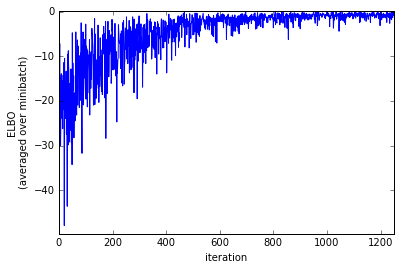

In [25]:
# Plot ELBO (variational lower bound objective) against iteration

plt.figure()
plt.plot(costs)
plt.axis('tight')
plt.xlabel('iteration')
plt.ylabel('ELBO\n(averaged over minibatch)')

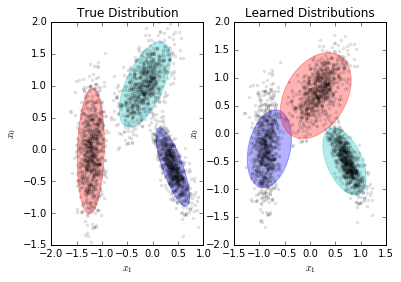

In [19]:
clr = ['b', 'r', 'c','g','m','o']

plt.figure()
plt.subplot(121)
plt.plot(ysamp[:,0], ysamp[:,1],'k.', alpha=.1)
plt.hold('on')
for ii in xrange(xDim):
    Rc= gmm.RChol[ii].eval()
    plot_cov_ellipse(Rc.dot(Rc.T), gmm.mu[ii].eval(), nstd=2, color=clr[ii%5], alpha=.3)
    
plt.title('True Distribution')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')

plt.subplot(122)
plt.hold('on')
plt.plot(ytrain[:,0], ytrain[:,1],'k.', alpha=.1)
for ii in xrange(xDim):
    Rc= model.mprior.RChol[ii].eval()
    plot_cov_ellipse(Rc.dot(Rc.T), model.mprior.mu[ii].eval(), nstd=2, color=clr[ii%5], alpha=.3)
    
plt.title('Learned Distributions')    
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')

plt.show()

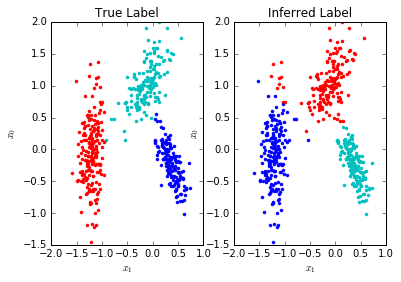

In [20]:
xlbl = xsamp.nonzero()[1]
#learned_lbl = model.mrec.h.eval({model.Y:ytrain}).argmax(axis=1)
#learned_lbl = model.mrec.getSample(ytrain).argmax(axis=1)
learned_lbl = model.mrec.h.argmax(axis=1).eval({model.Y:ytrain})

clr = ['b', 'r', 'c','g','m','o']

plt.figure()
for ii in np.random.permutation(xrange(500)):
    plt.subplot(121)
    plt.hold('on')
    plt.plot(ysamp[ii,0] ,ysamp[ii,1],'.', color = clr[xlbl[ii]%5])
    plt.subplot(122)
    plt.hold('on')
    plt.plot(ysamp[ii,0] ,ysamp[ii,1],'.', color = clr[learned_lbl[ii]%5])
    
plt.subplot(121)
plt.title('True Label')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
plt.subplot(122)
plt.title('Inferred Label')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
    
plt.show()


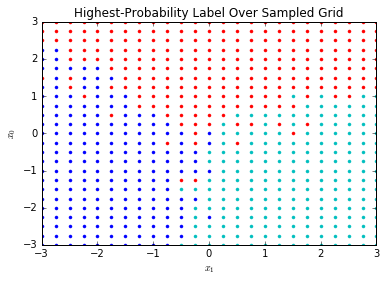

In [21]:
n = 25

x = np.linspace(-3, 3, n)
y = np.linspace(-3, 3, n)
xv, yv = np.meshgrid(x, y)
grid= np.vstack([xv.flatten(), yv.flatten()]).T

gridlabel = model.mrec.getSample(grid.astype(theano.config.floatX)).argmax(axis=1)

plt.figure()
plt.hold('on')
for ii in xrange(n*n):
    plt.plot(grid[ii,0] ,grid[ii,1],'.', color = clr[gridlabel[ii]%5])
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
plt.title('Highest-Probability Label Over Sampled Grid')
plt.show()